##### Goals -
- Create a decision tree model to predict severe damage
- Tune model hyperparameters
- Explain model predictions using gini importance
- Learn about three way split - Train-Validation-Test
- Iteration - Decision Tree, ordinal encoding, validation curve
- Communicate results - Gini Importance

A decision tree is comprised of nodes, parent nodes, child nodes etc.

In [50]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [51]:
def wrangle(db_path):
    # connect to database
    conn = sqlite3.connect(db_path)

    # construct query
    query = """
    SELECT DISTINCT i.building_id AS b_id, s.*, d.damage_grade
    FROM id_map as i
    JOIN building_structure as s ON i.building_id = s.building_id
    JOIN building_damage as d ON i.building_id = d.building_id
    WHERE district_id = 4
    """
    # Read query results into a dataframe
    df = pd.read_sql(query, conn, index_col="b_id")

    #Identify Leaky Features
    drop_cols = [col for col in df.columns if "post_eq" in col]

    #Create Binary Target
    # df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["damage_grade"] = df["damage_grade"].str.replace("Grade", "").str.strip().astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    drop_cols.append("damage_grade")

    #Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    #Drop high-cardinality categorical column
    drop_cols.append("building_id")

    #Drop Columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [52]:
df = wrangle("./data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


#### Preparing data from ML model

In [53]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True, random_state=42)

- setting up the baseline scores

In [56]:
majority_class, minority_class = y_test.value_counts(normalize=True)

In [57]:
acc_baseline = y_test.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round(acc_baseline,2))

Baseline Accuracy:  0.65


- Encoding categorical features through one hot encoding.

In [58]:
model = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(random_state=42)
)

- Training the Model

In [59]:
model.fit(X_train,y_train)

,steps,"[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,mapping,"[{'col': 'land_surface_condition', 'data_type': dtype('O'), 'mapping': Flat ...2 dtype: int64}, {'col': 'foundation_type', 'data_type': dtype('O'), 'mapping': Mud mortar-St...2 dtype: int64}, ...]"
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


- Evaluate model on Validation Data and Training Data

In [60]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))

In [61]:
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.98
Validation Accuracy: 0.65


<p style="color:red"> This means our model is overfitted</p>

#### Hyperparameter Tuning
- The depth of our decision is actually something that we can control. 
- It is a hyperparameter that we can tune 

In [62]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 49


In [63]:
depth_hyperparams = range(1,50,2)

In [64]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(random_state=42, max_depth=d)
        )
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.7071072484228174, 0.7117395332421582, 0.7162394670666608]
Validation Accuracy Scores: [0.7088406564319746, 0.7132521616375508, 0.7166049055937886]


- Plotting the Accuracy results for every hyperparameters

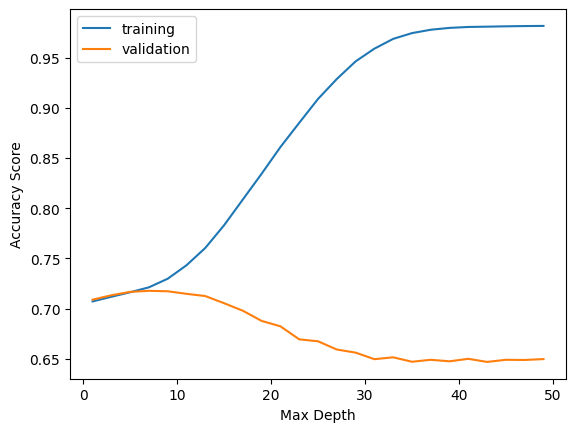

In [65]:
# Plot `depth_hyperparams`, `training_acc`

plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend()

- Training the model again with the best hyperparameter

In [66]:
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42, max_depth=6)
)

In [67]:
model.fit(X_train,y_train)

,steps,"[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,mapping,"[{'col': 'land_surface_condition', 'data_type': dtype('O'), 'mapping': Flat ...2 dtype: int64}, {'col': 'foundation_type', 'data_type': dtype('O'), 'mapping': Mud mortar-St...2 dtype: int64}, ...]"
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


In [68]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))

In [69]:
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.72
Validation Accuracy: 0.72


- Testing our Test our data

In [70]:
acc_val = accuracy_score(y_test, model.predict(X_test))
print("Test Accuracy:", round(acc_val, 2))

Test Accuracy: 0.72
